In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from random import sample
from collections import defaultdict
import graphviz 
import pandas

print('Loaded imports')

Loaded imports


In [2]:
# h1b_df = pandas.read_csv('../data/h1b.csv')
perm_df = pandas.read_csv('../data/perm.csv', thousands=",")
housing_df = pandas.read_csv('../data/housing.csv')

# h1b_df = h1b_df[['FULL_TIME_POSITION', 'YEAR', 'PREVAILING_WAGE', 'CASE_STATUS']]
perm_df = perm_df[['naics_2007_us_code', 'wage_offer_from_9089', 'case_status', 'wage_offer_unit_of_pay_9089', 'country_of_citzenship', 'employer_state', 'pw_level_9089']]
housing_columns = ['MSSubClass', 'LotArea', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterCond', 'CentralAir', 'YrSold']
housing_df = housing_df[housing_columns + ['SalePrice']]

# h1b_df = h1b_df.sample(n=100000)
print('Loaded dataframes')

/Users/philip/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loaded dataframes


In [3]:
# format data
datasetNum = 1

df = None
df_x = None
df_y = None
to_encode = []

classifed_names = None

if datasetNum == 0:
    df = h1b_df.copy()
    df_x = ['FULL_TIME_POSITION', 'YEAR', 'PREVAILING_WAGE']
    df_y = 'CASE_STATUS'
elif datasetNum == 1:
    df = perm_df.copy()
    df_x = [
        'wage_offer_from_9089',
        'naics_2007_us_code', 'wage_offer_unit_of_pay_9089', 'country_of_citzenship', 'employer_state', 'employer_state', 'pw_level_9089']
    df_y = 'case_status'
    to_encode = [ 'country_of_citzenship', 'employer_state', 'pw_level_9089']
elif datasetNum == 2:
    df = housing_df.copy()
    df_x = housing_columns
    df_y = 'price_bracket'
    to_encode = housing_columns
    
le = preprocessing.LabelEncoder
encoderDict = defaultdict(le)

for column in to_encode:
    print('Encoding: ' + column)
    df[column] = df[column].dropna()
    df = df[df[column].notnull()]
    df[column] = encoderDict[column].fit_transform(df[column])
    print(encoderDict[column].classes_)

if datasetNum == 0:
#     df['CITY'], df['STATE'] = df['WORKSITE'].str.split(',', 1).str
#     df['STATE'] = df['STATE'].str.strip()
#     df['STATE'].apply(str)

    df.loc[(df['FULL_TIME_POSITION'] == 'Y'), 'FULL_TIME_POSITION'] = 1
    df.loc[(df['FULL_TIME_POSITION'] == 'N'), 'FULL_TIME_POSITION'] = -1
    
    df = df[~df['CASE_STATUS'].str.contains("WITHDRAWN", na=True)]
    df = df[~df['CASE_STATUS'].str.contains("PENDING")]
    df = df[~df['CASE_STATUS'].str.contains("INVALIDATED")]
    df.loc[(df['CASE_STATUS'] == 'CERTIFIED'), 'CASE_STATUS'] = 1
    df.loc[(df['CASE_STATUS'] == 'CERTIFIED-WITHDRAWN'), 'CASE_STATUS'] = 1
    df.loc[(df['CASE_STATUS'] == 'DENIED'), 'CASE_STATUS'] = -1
    df.loc[(df['CASE_STATUS'] == 'REJECTED'), 'CASE_STATUS'] = -1
    
elif datasetNum == 1:
    df = df[~df['case_status'].str.contains("Withdrawn", na=False)]
    df.loc[(df['case_status'].str.contains('Certified', na=False)), 'case_status'] = 1
    df.loc[(df['case_status'].str.contains('Denied', na=False)), 'case_status'] = -1
    
    df.loc[(df['wage_offer_unit_of_pay_9089'].str.contains('yr', na=False)), 'wage_offer_unit_of_pay_9089'] = 2
    df.loc[(df['wage_offer_unit_of_pay_9089'].str.contains('hr', na=False)), 'wage_offer_unit_of_pay_9089'] = 1
    classifed_names = ['denied', 'approved']
elif datasetNum == 2:
    df['price_bracket'] = df['SalePrice'].copy().astype(int)
    
    classifed_names = []
    for bracket in range(0, 15):
        # Each bracket worth 75k
        bracket_width = 100000
        price_min = bracket * bracket_width
#         print(str(bracket) +': '+ str(price_min))
        price_max = price_min + bracket_width
        classifed_names.append(str(price_min) + '-' + str(price_max))
        df.loc[(df['SalePrice'] >= price_min), 'price_bracket'] = bracket
    
df = df.apply(lambda x: pandas.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))

print(df[:3])
# indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
# df = df[indices_to_keep]

print(df_x)
print(df_y)

print(df.columns)
print(df.dtypes)


Encoding: country_of_citzenship
['AFGHANISTAN' 'ALBANIA' 'ANGOLA' 'ARGENTINA' 'ARMENIA' 'AUSTRALIA'
 'AUSTRIA' 'AZERBAIJAN' 'BAHAMAS' 'BAHRAIN' 'BANGLADESH' 'BARBADOS'
 'BELARUS' 'BELGIUM' 'BELIZE' 'BHUTAN' 'BOLIVIA' 'BOSNIA AND HERZEGOVINA'
 'BRAZIL' 'BULGARIA' 'BURKINA FASO' 'BURMA (MYANMAR)' 'CAMBODIA' 'CAMEROON'
 'CANADA' 'CHILE' 'CHINA' 'COLOMBIA' 'COSTA RICA' 'CROATIA' 'CYPRUS'
 'CZECH REPUBLIC' 'DENMARK' 'DOMINICA' 'DOMINICAN REPUBLIC' 'ECUADOR'
 'EGYPT' 'EL SALVADOR' 'ESTONIA' 'ETHIOPIA' 'FIJI' 'FINLAND' 'FRANCE'
 'GAMBIA' 'GEORGIA' 'GERMANY' 'GHANA' 'GREECE' 'GRENADA' 'GUATEMALA'
 'GUINEA' 'GUYANA' 'HAITI' 'HONDURAS' 'HONG KONG' 'HUNGARY' 'ICELAND'
 'INDIA' 'INDONESIA' 'IRAN' 'IRAQ' 'IRELAND' 'ISRAEL' 'ITALY' 'IVORY COAST'
 'JAMAICA' 'JAPAN' 'JORDAN' 'KAZAKHSTAN' 'KENYA' 'KOSOVO' 'KUWAIT'
 'KYRGYZSTAN' 'LAOS' 'LATVIA' 'LEBANON' 'LESOTHO' 'LIBERIA' 'LIBYA'
 'LITHUANIA' 'MACEDONIA' 'MALAYSIA' 'MALI' 'MALTA' 'MAURITIUS' 'MEXICO'
 'MOLDOVA' 'MONGOLIA' 'MOROCCO' 'NEPAL' 'NETHERLAND

In [4]:
df = df.dropna()  
# sample = df.sample(n=10000)

# Shuffle
df = df.sample(frac=1).reset_index(drop=True)
print('Dataset size: ' + str(df.size))
print('Features: ' + str(df_x))
print('Trying to classify: ' + df_y)

X = df.loc[:, df_x]
y = df.loc[:, df_y]

trainTest = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=0)
print('hi')

Dataset size: 127652
Features: ['wage_offer_from_9089', 'naics_2007_us_code', 'wage_offer_unit_of_pay_9089', 'country_of_citzenship', 'employer_state', 'employer_state', 'pw_level_9089']
Trying to classify: case_status
hi


In [5]:
from sklearn.model_selection import GridSearchCV, learning_curve
from datetime import datetime
from sklearn.metrics import confusion_matrix

cross_validations = 4
train_sizes_base = [50, 60, 80, 100, 125, 150, 200, 300, 400, 500, 600, 700, 800]

def plot_learning_curve(title, cv_curve):
#     _, _, test_scores_base = base_curve
    train_sizes, train_scores, test_scores = cv_curve
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
#     test_scores_base_mean = np.mean(test_scores_base, axis=1)
#     test_scores_base_std = np.std(test_scores_base, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.ylim((.4, 1.01))
    
    if datasetNum == 1:
        plt.ylim((.55, 1.01))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    
#     plt.fill_between(train_sizes, test_scores_base_mean - test_scores_base_std,
#                      test_scores_base_mean + test_scores_base_std, alpha=0.1, color="b")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
#     plt.plot(train_sizes, test_scores_base_mean, 'o-', color="b",
#              label="Test Score without CV")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test Score with CV")

    plt.legend(loc="best")
    return plt

def crossValidateAndTest(name, clf, params, trainTest, scaler=None, plot=True):
    X_train, X_test, y_train, y_test = trainTest.copy()
    print('Name: ' + name)
    if not scaler is None:
        scaler.fit(X_train) 
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
#     base_clf = GridSearchCV(clf, param_grid=params, refit=True, cv=None)
    cv_clf = GridSearchCV(clf, param_grid=params, refit=True, cv=cross_validations)
    
#     base_clf.fit(X_train, y_train)
    
    start = datetime.now()
    cv_clf.fit(X_train, y_train)
    end = datetime.now()
    train_time = (end - start).total_seconds()
    train_score = cv_clf.score(X_train, y_train)
    print('Train time: ' + str(train_time))
    print('Train score: ' + str(train_score))
    
    start = datetime.now()
    test_score = cv_clf.score(X_test, y_test)
    end = datetime.now()
    test_time = (end - start).total_seconds()
    print('Test time: ' + str(test_time))
    print('Test score: ' + str(test_score))
    
    y_predict = cv_clf.predict(X_test)
    confusion_results = confusion_matrix(y_test, y_predict)
    print(confusion_results)
    
    
#     base_estimator = base_clf.best_estimator_
    cv_estimator = cv_clf.best_estimator_
    
    print("Best params: " + str(cv_clf.best_params_))
    
    table_output = '{:.4f} & {:.4f} & {:.4f} & {:.4f}'.format(train_score, train_time, test_score, test_time)
    
    
    
#     score = optimized_clf.score(X_test, y_test)
     
    additional_sizes = []
    if datasetNum == 1:
        additional_sizes = [1000, 1500, 2000, 2500, 3000]
        
    all_sizes = train_sizes_base + additional_sizes
#     base_curve = learning_curve(base_estimator, X_train, y_train, cv=None, train_sizes=all_sizes)

    if plot:
        cv_curve = learning_curve(cv_estimator, X_train, y_train, cv=cross_validations, train_sizes=all_sizes)

    #     plot = plot_learning_curve(name, base_curve, cv_curve)
        plot = plot_learning_curve(name, cv_curve) 

    
    return (cv_estimator, cv_clf, table_output)

print("Finished")

Finished


In [ ]:
# Decision Tree
params = { 'criterion':['gini','entropy'] }

for i in [1, 3, 6, 10, 15, 20, 25, 35, 50]: 
    clf = tree.DecisionTreeClassifier(max_depth=i, class_weight='balanced', splitter='best', min_samples_leaf=1)
    output, output_clf, table_output = crossValidateAndTest('Decision Tree: ' + str(i), clf, params, trainTest)
    tree_size = output.tree_.node_count
    print('{} & {} & {} & '.format(i, output_clf.best_params_['criterion'], tree_size) + table_output + ' \\\\ \\hline') 
    
    print()
#     clf = clf.fit(X_train, y_train)

#     y_predict = clf.predict(X_test)
#     scores = cross_val_score(clf, X, y)
#     print(str(i) + ': ' + str(accuracy_score(y_test, y_predict)) + '   |   ' + str(scores.mean()))
    if i == 7:
        dot_data = tree.export_graphviz(output, out_file=None, 
                             feature_names=df_x,  
                             class_names=classifed_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  
        graph = graphviz.Source(dot_data).view()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
estimators = [1, 3, 5, 15, 50, 100, 150]
learning_rate = [.1, 1, 10]

for i in [1, 3, 5, 10, 15, 20]: 
    clf_base = tree.DecisionTreeClassifier(max_depth=i, criterion='gini', splitter='best')
    clf = AdaBoostClassifier(base_estimator=clf_base)
    output, output_clf, table_output = crossValidateAndTest('Adaboost: ' + str(i), clf, {'n_estimators': estimators, 'learning_rate': learning_rate}, trainTest)
    tree_count = len(output)
    print('{} & {} & {} & '.format(i, output_clf.best_params_['learning_rate'], output_clf.best_params_['n_estimators']) + table_output + ' \\\\ \\hline') 
    
# for estimator in estimators:
#     clf = AdaBoostClassifier(n_estimators=estimator)
    
#     crossValidateAndTest('Adaboost: ' + str(estimator), clf, {}, trainTest)
    
#     clf = clf.fit(X_train, y_train)

#     y_predict = clf.predict(X_test)
#     scores = cross_val_score(clf, X, y)
#     print(str(estimator) + ': ' + str(accuracy_score(y_test, y_predict)) + '   |   ' + str(scores.mean()))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  


alphas = [0.0001, ]#0.005, 0.001]
learning_rate_inits = [ 0.001, ]#.01, .1, .2]
activations = ['relu']
layers = []

for i in [5,10,100]:
    for j in [1, 3]:
        layers.append((i, j))
        
# params = { 'alpha': alphas, 'learning_rate_init': learning_rate_init}
params = {}

print("Starting neural networks")
for alpha in alphas:
    for learning_rate_init in learning_rate_inits:
        clf = MLPClassifier(solver='adam', max_iter=2000, random_state=7, batch_size='auto')
        plot = True
        output, output_clf, table_output = crossValidateAndTest('Adam NN: ' + str(alpha) + '/' + str(learning_rate_init), clf, params, trainTest, StandardScaler(), plot)
        print(str(output.n_iter_))
        print('{} & {} & '.format(alpha, learning_rate_init) + table_output + ' \\\\ \\hline') 
        
        clf = MLPClassifier(solver='sgd', max_iter=2000, random_state=7, batch_size='auto')
        plot = True
        output, output_clf, table_output = crossValidateAndTest('SGD NN: ' + str(alpha) + '/' + str(learning_rate_init), clf, params, trainTest, StandardScaler(), plot)
        print(str(output.n_iter_))
        print('{} & {} & '.format(alpha, learning_rate_init) + table_output + ' \\\\ \\hline') 




# for iteration_count in iterations:
#     for layer_size_1 in layer_sizes_1:
#         for layer_size_2 in layer_sizes_2:
#             clf = MLPClassifier(solver='sgd', activation='relu', max_iter=iteration_count, alpha=0.001, batch_size=200, hidden_layer_sizes=(layer_size_1, layer_size_2), random_state=42)
#             scaler.fit(X_train) 

#             X_train_new = scaler.transform(X_train)
#             X_test_new = scaler.transform(X_test)
#             clf.fit(X_train_new, y_train)
#             y_predict = clf.predict(X_test_new)
#             print(str(iteration_count) + ':' + str((layer_size_1, layer_size_2)) + ': ' + str(accuracy_score(y_test, y_predict)))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]


def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)
#     ax.xlabel("# Iterations")
#     ax.ylabel("Loss")
    X = MinMaxScaler().fit_transform(X)
    mlps = []
    if name == "digits":
        # digits is larger but converges fairly quickly
        max_iter = 15
    else:
        max_iter = 1000

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(verbose=0, random_state=0,
                            max_iter=max_iter, **param)
        
        start = datetime.now()
        mlp.fit(X, y)
        end = datetime.now()
        train_time = (end - start).total_seconds()
        
        start = datetime.now()
        score = mlp.score(X, y)
        end = datetime.now()
        score_time = (end - start).total_seconds()
        
        table_output = '{} & {:.4f} & {:.4f} & {:.4f}'.format(label, score, mlp.loss_, train_time)
        print(table_output)

        
        mlps.append(mlp)
        print("Training set score: %f" % score)
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)
        


fig, axes = plt.subplots(1, 1, figsize=(15, 5))
# load / generate some toy datasets

ax = axes
plot_on_dataset(X, y, ax, 'Test')

plt.xlabel("# Iterations")
plt.ylabel("Loss")
fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler  

kernels = ['rbf', 'poly']
gammas = [0.01, .05, 1.0, 2.0]
for kernel in kernels:
    for gamma in gammas:
        clf_1 = svm.SVC(kernel=kernel, max_iter=30000, gamma=gamma)
        output, output_clf, table_output = crossValidateAndTest('SVM ' + kernel + ' - ' + str(gamma), clf_1, {}, trainTest, StandardScaler())
        print('{} & {} & '.format(kernel, gamma) + table_output + ' \\\\ \\hline') 


Running knn
Name: KNN: 1
Train time: 0.342165
Train score: 0.970814038508
Test time: 0.00797
Test score: 0.815789473684
[[  85  168]
 [ 168 1403]]
Best params: {}
uniform & 1 & 0.9708 & 0.3422 & 0.8158 & 0.0080 \\ \hline

Name: KNN: 2
Train time: 0.361917
Train score: 0.89775773824
Test time: 0.009404
Test score: 0.770833333333
[[ 117  136]
 [ 282 1289]]
Best params: {}
uniform & 2 & 0.8978 & 0.3619 & 0.7708 & 0.0094 \\ \hline

Name: KNN: 3
Train time: 0.360258
Train score: 0.898915427736
Test time: 0.010566
Test score: 0.839364035088
[[  70  183]
 [ 110 1461]]
Best params: {}
uniform & 3 & 0.8989 & 0.3603 & 0.8394 & 0.0106 \\ \hline

Name: KNN: 4
Train time: 0.383629
Train score: 0.885388739946
Test time: 0.010346
Test score: 0.820175438596
[[  87  166]
 [ 162 1409]]
Best params: {}
uniform & 4 & 0.8854 & 0.3836 & 0.8202 & 0.0103 \\ \hline

Name: KNN: 5
Train time: 0.399554
Train score: 0.889166463563
Test time: 0.010653
Test score: 0.850328947368
[[  64  189]
 [  84 1487]]
Best param

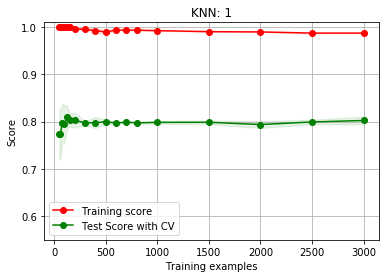

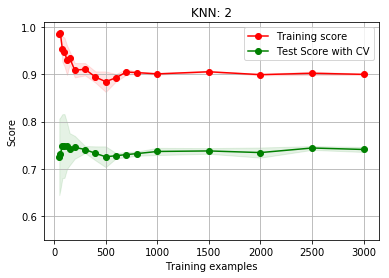

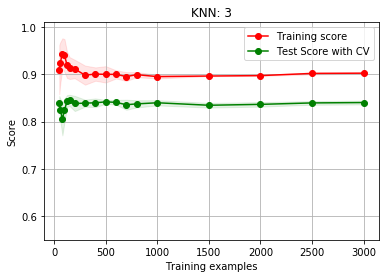

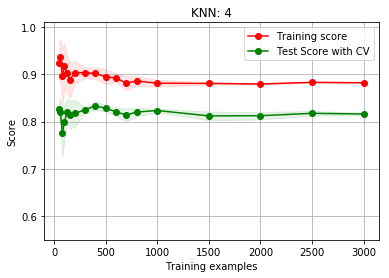

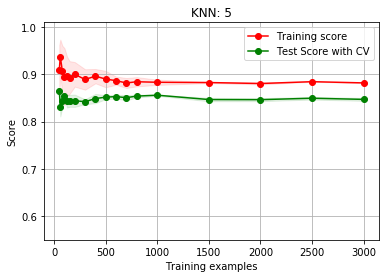

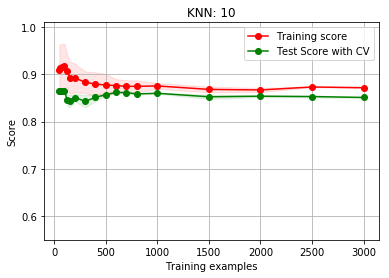

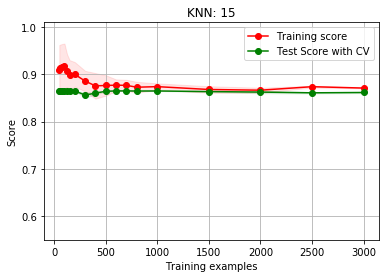

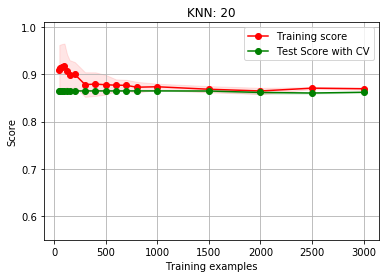

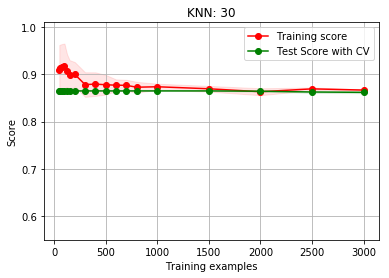

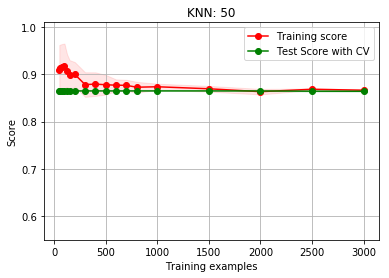

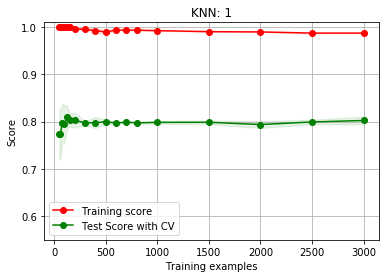

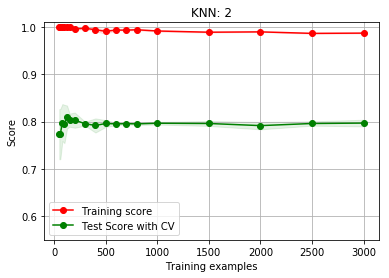

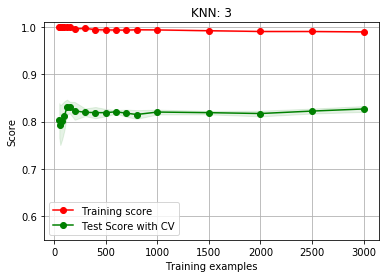

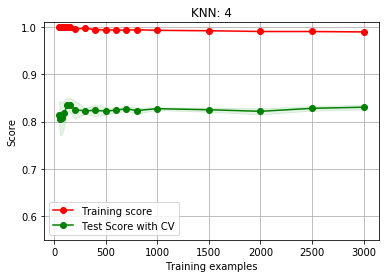

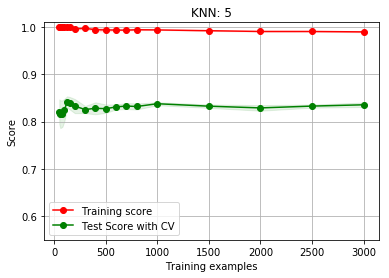

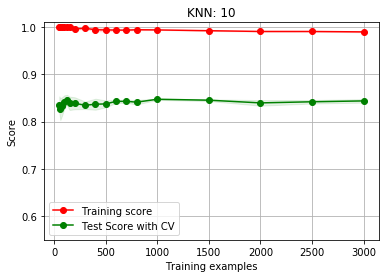

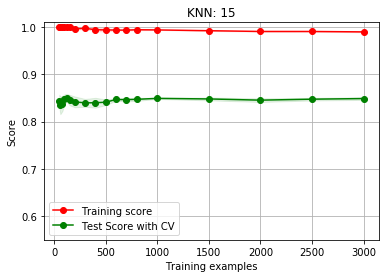

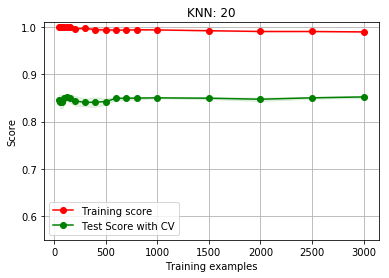

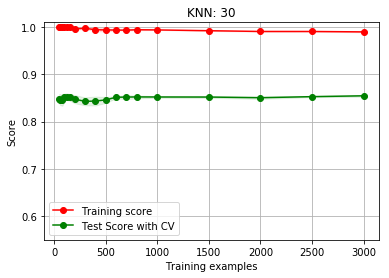

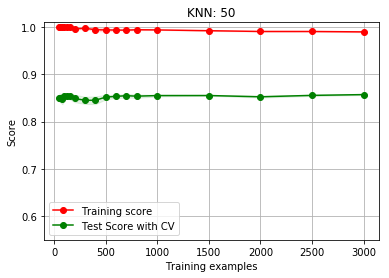

In [7]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors

print('Running knn')
h = .02  # step size in the mesh

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

weights = ['uniform', 'distance']
k_vals = [1, 2, 3, 4, 5, 10, 15, 20, 30, 50]

for weight in weights:
    for k in k_vals:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(k, weights=weight)
        output, output_clf, table_output = crossValidateAndTest('KNN - ' + weight + ': ' + str(k), clf, {}, trainTest)
        print('{} & {} & '.format(weight, k) + table_output + ' \\\\ \\hline') 

        print()
#         clf.fit(X_train, y_train)
        
#         y_predict = clf.predict(X_test)
#         scores = cross_val_score(clf, X, y)
#         print(str(k) + ':' + weight + ': ' + str(accuracy_score(y_test, y_predict)) + '   |   ' + str(scores.mean()))
